# Overfit and underfit

In previous examples-classifiying text and predicting the fuel efficiency- we saw that the accuracy of the models on the validation data would peak after training for a number of epochs, and would then stagnate or start decreasing.

In other words, our model would *overfit* to the training data. Learning how to deal with overfitting is important. Although it's often possible to achieve high accuracy on the *training set*, what we really want is to develop models that generalize well to a *testing set* (or data they haven't seen before).

The opposite of overfitting is *underfitting*. Underfitting occurs when there is still room for improvement on the train data. This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. This means the network has not learned the relevant patterns in the training data.

If you train for too long though, the model will start to overfit and learn patterns from the training data that don't generalize to the test data. We need to strike a balance. Understanding how to train for an appropiate number of epochs as we'll explore below is a useful skill.

To prevent overfitting, the best solution is to use more complete training data. The dataset should cover the full ranfge of inputs that the model is expected to handle. Additional data may only be useful if it covers new and interesting cases.

A model trained on more complete data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like regularization. These place constraints on the quantity and type of information your model can store. If a network can only afford to memorize a small number of patterns, the optimization process will for it to focus on the most prominent patterns, which have a better chance of generalizing well.

In this notebook, we'll explore several common regularization techniques, and use them to improve on a classification model.


In [4]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [1]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [2]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

In [3]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# The Higgs Dataset

The goal of this tutorial is not to particle physics, so we don't dwell on the details of the dataset. It contains 11,000,000 examples, each with 28 features, and a binary class label.

In [5]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 150s 0us/step


In [6]:
FEATURES = 28

The ```tf.data.experimental.CsvDataset``` class can be used to read csv records directly from a gzip file with no intermediate decompression step

In [7]:
ds = tf.data.experimental.CsvDataset(gz, [float(),]*(FEATURES+1), compression_type='GZIP')

2021-07-28 12:14:52.862673: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-28 12:14:52.862702: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-28 12:14:52.862721: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (leno-lab): /proc/driver/nvidia/version does not exist
2021-07-28 12:14:52.862948: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


That csv reader class return a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [8]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

TensorFlow is most efficient when operating on large batches of data.

So instead of repacking each row individually make a new ```Dataset``` that takes batches of 10000-examples, applies the ```pack_row``` function to each batch, and then splits the batches back up into individual records:

In [9]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

Have a look at some of the records from this new ```packed_ds```.

The features are not perfectly normalized, but this is sufficient for this tutorial.

2021-07-28 12:22:21.578169: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-28 12:22:21.578699: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3194440000 Hz


tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


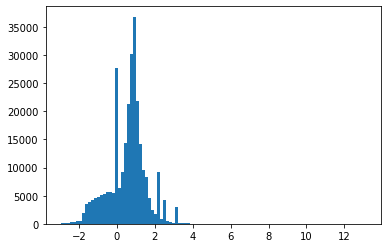

In [10]:
for features, label in packed_ds.batch(10000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

To keep this relatively short, we'll use just the first 1000 samples for validation, and the next 10000 for training:

In [11]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN/BATCH_SIZE

The ```Dataset.skip``` and ```Dataset.take``` methods make this easy.

At the same time, use the ```Dataset.cache``` method to ensure that the loader doesn't need to re-read the data from the file on each epoch:

In [12]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [13]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

These datasets return individual examples. Use the ```batch``` method to create batches of an appropiate size for training. Before batche also remember to ```.shuffle``` and ```.repeat``` the training set.

In [14]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

# Demonstrate overfitting

The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".

Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".

Unfornately, there is not magical formula to determine the right size of architecture of you r model (in terms of the numbers of layers, or the right size for each layer). You will have to experiment using a series of different architectures.

To find an appropiate size, it's best to start with a relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.

Start with a simple model using only ```layers.Dense``` as baseline, then create larger versions, and compare them.


# Training procedure

Many models train better if you gradually reduce the learning rate during training. Use ```optimizers.schedules``` to reduce the learning rate over time:

In [15]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001,
                                                             decay_steps=STEPS_PER_EPOCH*1000,
                                                             decay_rate=1,
                                                             staircase=False)

In [16]:
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

The code above sets a ```schedules.InverseTimeDecay``` to hyperbolically decrease the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs and so on

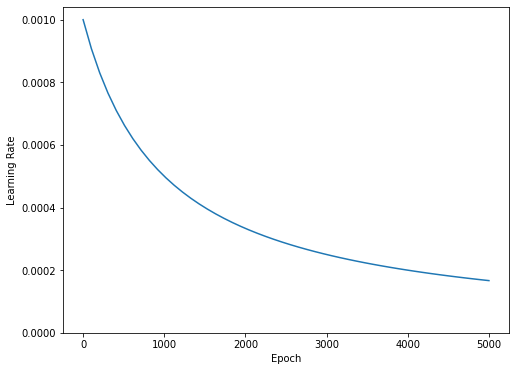

In [18]:
step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

Each model in this tutorial will use the same training configuration. So set these up in a reusable way, starting with the list of callbacks.

The training for this tutorial runs for many short epochs. To reduce the logging noise use the ```tfdocs.EpochDtos``` which simply prints a ```.``` for each epoch, and a full set of metrics every 100 epochs.

Next, include ```callbacks.EarlyStopping``` to avoid long and unnecessary training times. Note that this callback is set to monitor the ```val_binary_crossentropy```, not the ```val_loss```. This difference will be important later.

Use ```callbacks.TensorBoard``` to generate TensorBoard logs for the training.

In [19]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name)
    ]

Similarly each model will use the same ```Model.compile``` and ```Model.fit``` settings:

In [20]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[
                      tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),
                      'accuracy'
                  ])
    model.summary()
    history = model.fit(
        train_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0)
    return history

# Tiny model 

Start by training a model:


In [21]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [22]:
size_histories = {}

In [23]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


2021-07-28 12:52:02.632351: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-28 12:52:02.632423: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-28 12:52:02.633214: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


2021-07-28 12:52:04.233491: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-28 12:52:04.233523: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-28 12:52:04.237137: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-07-28 12:52:04.243015: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-07-28 12:52:04.253867: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpip7vzgpl/tensorboard_logs/sizes/Tiny/train/plugins/profile/2021_07_28_12_52_04
2021-07-28 12:52:04.260342: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to /tmp/tmpip7vzgpl/tensorboard_logs/sizes/Tiny/train/plugins/profile/2021_07_28_12_52_04/leno-lab.trace.json.gz
2021-07-28 12:52:04.265465: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /t


Epoch: 0, accuracy:0.5004,  binary_crossentropy:0.7677,  loss:0.7677,  val_accuracy:0.4530,  val_binary_crossentropy:0.7576,  val_loss:0.7576,  
....................................................................................................
Epoch: 100, accuracy:0.6085,  binary_crossentropy:0.6214,  loss:0.6214,  val_accuracy:0.5980,  val_binary_crossentropy:0.6212,  val_loss:0.6212,  
....................................................................................................
Epoch: 200, accuracy:0.6326,  binary_crossentropy:0.6075,  loss:0.6075,  val_accuracy:0.6290,  val_binary_crossentropy:0.6022,  val_loss:0.6022,  
....................................................................................................
Epoch: 300, accuracy:0.6518,  binary_crossentropy:0.5981,  loss:0.5981,  val_accuracy:0.6070,  val_binary_crossentropy:0.5998,  val_loss:0.5998,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

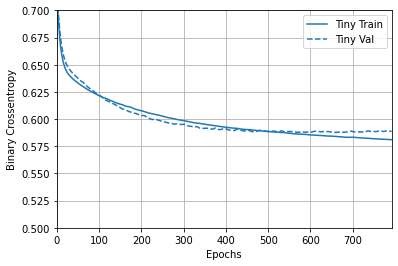

In [24]:
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

# Small model

To see if you can beat the performance of the small model, progressively train some larger models.

Try two hidden layers with 16 units each:

In [25]:
small_model = tf.keras.Sequential([
    # input_shape is only required here so that .summary works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [26]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________


2021-07-28 13:22:35.915907: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-28 13:22:35.915942: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-28 13:22:35.916007: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.



Epoch: 0, accuracy:0.4718,  binary_crossentropy:0.7182,  loss:0.7182,  val_accuracy:0.4620,  val_binary_crossentropy:0.7006,  val_loss:0.7006,  
.

2021-07-28 13:22:36.520200: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-28 13:22:36.520234: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-28 13:22:36.547955: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-07-28 13:22:36.552798: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-07-28 13:22:36.562526: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpip7vzgpl/tensorboard_logs/sizes/Small/train/plugins/profile/2021_07_28_13_22_36
2021-07-28 13:22:36.568888: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to /tmp/tmpip7vzgpl/tensorboard_logs/sizes/Small/train/plugins/profile/2021_07_28_13_22_36/leno-lab.trace.json.gz
2021-07-28 13:22:36.573081: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: 

...................................................................................................
Epoch: 100, accuracy:0.6488,  binary_crossentropy:0.5993,  loss:0.5993,  val_accuracy:0.6440,  val_binary_crossentropy:0.6002,  val_loss:0.6002,  
....................................................................................................
Epoch: 200, accuracy:0.6740,  binary_crossentropy:0.5813,  loss:0.5813,  val_accuracy:0.6810,  val_binary_crossentropy:0.5794,  val_loss:0.5794,  
....................................................................................................
Epoch: 300, accuracy:0.6831,  binary_crossentropy:0.5728,  loss:0.5728,  val_accuracy:0.6630,  val_binary_crossentropy:0.5809,  val_loss:0.5809,  
....................................................................................................
Epoch: 400, accuracy:0.6907,  binary_crossentropy:0.5658,  loss:0.5658,  val_accuracy:0.6600,  val_binary_crossentropy:0.5820,  val_loss:0.5820,  
.........

# Medium model

Now try with 3 hidden layers with 64 units each:

In [27]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [28]:
size_histories['Medium'] = compile_and_fit(medium_model, 'sizes/Medium')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________


2021-07-28 13:29:24.668963: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-28 13:29:24.669026: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-28 13:29:24.670252: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


2021-07-28 13:29:25.064033: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-28 13:29:25.064060: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-28 13:29:25.092959: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-07-28 13:29:25.098138: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-07-28 13:29:25.108331: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpip7vzgpl/tensorboard_logs/sizes/Medium/train/plugins/profile/2021_07_28_13_29_25
2021-07-28 13:29:25.114773: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to /tmp/tmpip7vzgpl/tensorboard_logs/sizes/Medium/train/plugins/profile/2021_07_28_13_29_25/leno-lab.trace.json.gz
2021-07-28 13:29:25.119489: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory


Epoch: 0, accuracy:0.5020,  binary_crossentropy:0.7000,  loss:0.7000,  val_accuracy:0.4770,  val_binary_crossentropy:0.6754,  val_loss:0.6754,  
....................................................................................................
Epoch: 100, accuracy:0.7178,  binary_crossentropy:0.5333,  loss:0.5333,  val_accuracy:0.6460,  val_binary_crossentropy:0.6138,  val_loss:0.6138,  
....................................................................................................
Epoch: 200, accuracy:0.7829,  binary_crossentropy:0.4351,  loss:0.4351,  val_accuracy:0.6320,  val_binary_crossentropy:0.7028,  val_loss:0.7028,  
..............................................

# Large model

As an exercise, we can create an even larger model, and see how quickly it begins overfitting. Next, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [29]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [30]:
size_histories['Large'] = compile_and_fit(large_model, 'sizes/large')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________


2021-07-28 13:38:19.437652: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-28 13:38:19.437706: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-28 13:38:19.438008: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-07-28 13:38:19.874687: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-28 13:38:19.874715: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-28 13:38:19.915405: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-07-28 13:38:19.919882: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-07-28 13:38:19.929528: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpip7vzgpl/tensorboard_logs/sizes/large/train/plugins/profile/2021_07_28_13_38_19
2021-07-28 13:


Epoch: 0, accuracy:0.5184,  binary_crossentropy:0.8212,  loss:0.8212,  val_accuracy:0.4800,  val_binary_crossentropy:0.6850,  val_loss:0.6850,  
....................................................................................................
Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0022,  loss:0.0022,  val_accuracy:0.6600,  val_binary_crossentropy:1.7918,  val_loss:1.7918,  
....................................................................................................
Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6550,  val_binary_crossentropy:2.4688,  val_loss:2.4688,  
...........................

# Plot the training and validation losses

The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model)

While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.

In this example, typically, only the ```Tiny``` model manages to avoid overfitting altogether, and each of the larger models overfit the data more quickly. This becomes so severe for the ```Large``` model that you need to switch the plot to a log-scale to really see what's happening.

This is apparent if you plot and compare the validation metrics to the training metrics.
    - It's normal for there to be a small difference.
    - If both metrics are moving in the same direction, everything is fine.
    - If the validation matric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
    - If the validation metric is going in the wrong direction, the model is clearly overfitting.

Text(0.5, 0, 'Epochs [Log Scale]')

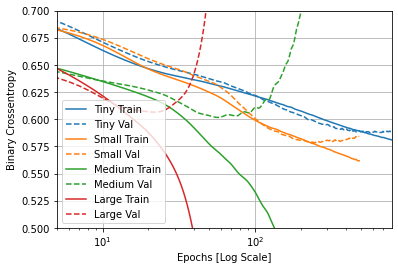

In [31]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

# View in TensorBoard

These models all wrote TensorBoard logs during training.

Open an embedded TensorBoard viewer inside a notebook:

In [32]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

You can view the results of a previous run of this notebook on TensorBoard.dev

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It's also included in an ```<iframe>``` for convenience:

In [33]:
display.IFrame(
    src='https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97',
    width='100%', height='800px')

# Strategies to prevent overfitting

Before getting into the content of this section, copy the training logs from the ```Tiny``` model above, to use as baseline for comparison.

In [34]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpip7vzgpl/tensorboard_logs/regularizers/Tiny')

In [35]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

# Add weight regularization

You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called weight regularization, and it is done by adding the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

    - L1 Regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).
    - L2 Regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural network. Don't let the different name confuse you: weight decay is mathematically the same as L2 regularization.
    
L1 regularization pushes weights towards encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights-one reason why L2 is more common.

In ```tf.keras```, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. 

Let's add L2 weight regularization now.

In [36]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                kernel_regularizer=regularizers.l2(0.001),
                input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

In [37]:
regularizer_histories['l2'] = compile_and_fit(l2_model, 'regularizers/l2')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 513       
Total params: 540,673
Trainable params: 540,673
Non-trainable params: 0
_________________________________________________________________


2021-07-28 14:45:42.001601: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-28 14:45:42.001812: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-28 14:45:42.001945: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-07-28 14:45:42.487573: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-28 14:45:42.487601: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-28 14:45:42.531182: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-07-28 14:45:42.536868: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-07-28 14:45:42.547503: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpip7vzgpl/tensorboard_logs/regularizers/l2/train/plugins/profile/2021_07_28_14_45_42
2021-07-28


Epoch: 0, accuracy:0.5074,  binary_crossentropy:0.8026,  loss:1.8336,  val_accuracy:0.5830,  val_binary_crossentropy:0.6815,  val_loss:1.6570,  
....................................................................................................
Epoch: 100, accuracy:0.6532,  binary_crossentropy:0.5983,  loss:0.6188,  val_accuracy:0.6530,  val_binary_crossentropy:0.5817,  val_loss:0.6022,  
....................................................................................................
Epoch: 200, accuracy:0.6704,  binary_crossentropy:0.5834,  loss:0.6050,  val_accuracy:0.6730,  val_binary_crossentropy:0.5771,  val_loss:0.5988,  
....................................................................................................
Epoch: 300, accuracy:0.6789,  binary_crossentropy:0.5754,  loss:0.5980,  val_accuracy:0.6390,  val_binary_crossentropy:0.5852,  val_loss:0.6077,  
....................................................................................................
Epoch: 40

```l2(0.001)``` means that every coefficient in the weight matrix of the layer will add ```0.001 * weight_coefficient_value**2``` to the total loss of the network.

That is why we're monitoring the ```binary_crossentropy``` directly. Because it doesn't have this regularization component mixed in.

So, that same ```Large``` model with an ```L2``` regularization penalty performs much better:

(0.5, 0.7)

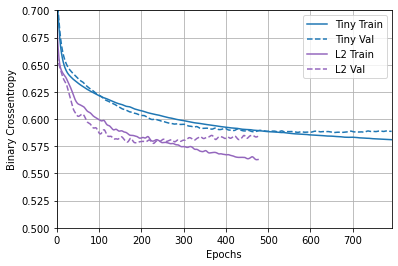

In [38]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

As you can see, the ```L2``` regularized model is now much more competitive with the ```Tiny``` model. This ```L2``` model is also much more resistant to overfitting than the ```Large``` model it was based on despite having the same number of parameters.

**More info**
There are two important things to note about this sort of regularization.
**First**: if you are writting your own training loop, then you need to be sure to ask the model for its regularization looses.

In [39]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

2021-07-28 15:02:29.904515: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 20480000 exceeds 10% of free system memory.
2021-07-28 15:02:29.910324: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 20480000 exceeds 10% of free system memory.
2021-07-28 15:02:29.918579: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 20480000 exceeds 10% of free system memory.
2021-07-28 15:02:29.936529: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 20480000 exceeds 10% of free system memory.
2021-07-28 15:02:29.969902: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 20480000 exceeds 10% of free system memory.


**Second:** This implementation works by adding the weight penalties to the model's loss, and then applying a standard optimization procedure after that.

There is a second approach that instead only runs the optimizer on the raw loss, and then while applying the calculated step the optimizer also applies some weight decay. This "Decoupled Weight Decay" is seen in optimizers like ```optimizers.FTRL``` and ```optimizer.AdamW```

# Add dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.5, 0.5, 1.3, 0.8, 1.1] for given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, eg. [0, 0.5, 1.3, 0, 1.1].

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In ```tf.keras``` you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layers right before.

Let's add two Dropout layers in our network to see how well they do at reducing overfitting:

In [40]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

In [41]:
regularizer_histories['Dropout'] = compile_and_fit(dropout_model, 'regularizers/dropout')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                

2021-07-28 15:14:12.308123: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-28 15:14:12.308151: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-28 15:14:12.308754: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-07-28 15:14:12.807976: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-28 15:14:12.808005: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-28 15:14:12.862034: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-07-28 15:14:12.867786: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-07-28 15:14:12.879583: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpip7vzgpl/tensorboard_logs/regularizers/dropout/train/plugins/profile/2021_07_28_15_14_12
2021-


Epoch: 0, accuracy:0.5148,  binary_crossentropy:0.7522,  loss:0.7522,  val_accuracy:0.5410,  val_binary_crossentropy:0.6610,  val_loss:0.6610,  
....................................................................................................
Epoch: 100, accuracy:0.6527,  binary_crossentropy:0.5968,  loss:0.5968,  val_accuracy:0.6630,  val_binary_crossentropy:0.5819,  val_loss:0.5819,  
....................................................................................................
Epoch: 200, accuracy:0.6911,  binary_crossentropy:0.5671,  loss:0.5671,  val_accuracy:0.6890,  val_binary_crossentropy:0.5752,  val_loss:0.5752,  
....................................................................................................
Epoch: 300, accuracy:0.7148,  binary_crossentropy:0.5314,  loss:0.5314,  val_accuracy:0.7020,  val_binary_crossentropy:0.5928,  val_loss:0.5928,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

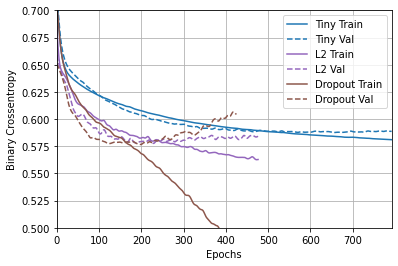

In [42]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

It's clear from this plot that both of these regularization approches improve the behavior of the ```Large``` model. But this still doesn't beat even the ```Tiny``` baseline model.

Next try them both, together, and see if that does better.

# Combined L2 dropout

In [43]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,),
                kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(1)
])

In [44]:
regularizer_histories['Combined'] = compile_and_fit(combined_model, 'regularizers/combined')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)              

2021-07-28 15:24:01.931931: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-28 15:24:01.931961: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-28 15:24:01.933187: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-07-28 15:24:02.546788: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-28 15:24:02.546823: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-28 15:24:02.614525: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-07-28 15:24:02.620547: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-07-28 15:24:02.631372: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmpip7vzgpl/tensorboard_logs/regularizers/combined/train/plugins/profile/2021_07_28_15_24_02
2021


Epoch: 0, accuracy:0.5034,  binary_crossentropy:0.7992,  loss:0.9573,  val_accuracy:0.4810,  val_binary_crossentropy:0.6811,  val_loss:0.8386,  
....................................................................................................
Epoch: 100, accuracy:0.6497,  binary_crossentropy:0.6036,  loss:0.6333,  val_accuracy:0.6540,  val_binary_crossentropy:0.5853,  val_loss:0.6148,  
....................................................................................................
Epoch: 200, accuracy:0.6512,  binary_crossentropy:0.5940,  loss:0.6200,  val_accuracy:0.6690,  val_binary_crossentropy:0.5768,  val_loss:0.6028,  
....................................................................................................
Epoch: 300, accuracy:0.6699,  binary_crossentropy:0.5822,  loss:0.6109,  val_accuracy:0.6740,  val_binary_crossentropy:0.5696,  val_loss:0.5983,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

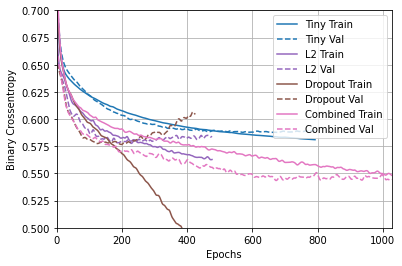

In [45]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

This model with the ```Combined``` regularization is obviously the best one so far.

# View on TensorBoard

These models also recorded TensorBoard logs.
To open an embedded tensorboard viewer inside a notebook:

In [46]:
%tensorboard --logdir {logdir}/regularizers

# Conclusions

To recap: here are the most common ways to prevent overfitting in neural networks:

    - Get more training data.
    - Reduce the capacity of the network
    - Add weight regularization
    - Add dropout.
    
Two more important approaches not covered in this guide are:

    - Data-augmentation.
    - Batch Normalization.